In [1]:
import os
import json
import random
from datetime import datetime
import tempfile
import base64
from pathlib import Path

import glob
import json

import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/src/functionapp")
#On windows use  sys.path.append(module_path+"\\src\\functionapp")

from ai_ocr.azure.openai_ops_sk import load_image, get_size_of_base64_images
from ai_ocr.azure.images import convert_pdf_into_image
from ai_ocr.model import Config
from ai_ocr.chains_sk import get_structured_data
from ai_ocr.azure.doc_intelligence import get_ocr_results

# from langchain_core.output_parsers.json import parse_json_markdown

from dotenv import load_dotenv
load_dotenv()

True

### Run the Solution once on the demo to produce an output.json

In [7]:
#input_directory = '../demo/medical-dataset/'
input_directory = '../demo/default-dataset/'
#input_directory = '../demo/eval-dataset/'

system_prompt =  ''
with open(input_directory+'system_prompt.txt', 'r') as file_sys_prompt:
    system_prompt = file_sys_prompt.read()

output_schema = ''
with open(input_directory+'output_schema.json', 'r') as file_output_schema:
    output_schema = file_output_schema.read()

# Create a dict with content key to store the OCR results
ocr_result = {
    "content": ""
}

# Loop over directory and process all PDFs
for file in os.listdir(input_directory):
    if file.endswith(".pdf"):
        ocr_result["content"] += get_ocr_results(input_directory+file).content

        # Extract images from the PDF
        convert_pdf_into_image(input_directory+file)
    
 # Ensure the /tmp/ directory exists
imgs_path = "./tmp/"
os.makedirs(imgs_path, exist_ok=True)
    
# Determine the path for the temporary images
imgs = glob.glob(f"{imgs_path}/page*.png")
    
# Limit images by config
config = Config()
print(f"Config img size: {config.max_images}")
imgs = imgs[:config.max_images]
imgs = [load_image(img) for img in imgs]
print(f"Images count: {len(imgs)}")

# Check and reduce images total size if over 20MB
#max_size = 20 * 1024 * 1024  # 20MB
#while get_size_of_base64_images(imgs) > max_size:
#    imgs.pop()
    
# Get structured data
structured = await get_structured_data(ocr_result["content"], system_prompt, output_schema, imgs)
    
# Parse structured data and return as JSON
# Parse structured data
stripped_content = structured.content.strip()
x = json.loads(stripped_content)
response = json.dumps(x)

print(f'Response: {response}')

actual_output_path = "/tmp/output.json"
with open(actual_output_path, 'w') as f:
    f.write(response)

Saved image: c:/tmp/page_1.png
Config img size: 10
Images count: 0
Response: {"Customer Name": "Henry Ross", "Invoice Number": "1234", "Date": "November 30, 2022", "Billing info": {"Customer": "Henry Ross", "Customer ID": "8675309", "Address": "123 Avenue A, Metropolis", "Phone": "(123) 456-7890"}, "Payment Due": "December 30, 2022", "Salesperson": "Luca Richter", "Payment Terms": "Cash or check", "Shipping info": {"Recipient": "Henry Ross", "Address": "123 Avenue A, Metropolis", "Phone": "(123) 456-7890"}, "Delivery Date": "December 7, 2022", "Shipping Method": "Ground", "Shipping Terms": "Returns not accepted", "Table": {"Items": [{"Qty": "10", "Item#": "123", "Description": "Baby chicks", "Unit price": "5.00", "Discount": "10%", "Line total": "45.00"}, {"Qty": "2", "Item#": "444", "Description": "Heat lamps", "Unit price": "24.00", "Discount": "", "Line total": "48.00"}, {"Qty": "6", "Item#": "120", "Description": "Chicken roosts", "Unit price": "30.00", "Discount": "", "Line total"

## 1. Evaluating with the LLM

### Load the input (an output from previous LLM run) and evaluate using LLM as a judge

In [8]:
from semantic_kernel.contents import ChatHistory, ChatMessageContent, ImageContent


from ai_ocr.azure.openai_ops_sk import get_completion_service

with open(actual_output_path, 'r') as f:
    input = f.readlines()

#print(input)

system_message = f"""

         You are the OpenAI model that can extract and describe images provided by the user in extreme detail. 
         The user attached images to this message for you to analyse, there is MOST DEFINITELY an image attached, you will never reply saying that you cannot see the image because the image is absolutely and always attached to this message.
         
         Your tasks are the following:
         1. Use the images provided to extract all the data using this customs instructions:
            ```
            {system_prompt}
            ```
            and fit the data following the provided JSON schema:
            ```
            {output_schema}
            ```
            No need to output this extraction in your response.

         2. Compare the data provided in the json input fields against what you have extracted from the images at task 1.

            For each individual field in the json input, how confident you are that what you've extracted from the images field is accurate compared to the same field in the json input? Assign a confidence score between 0 and 1, using the following guidelines:
            - 1.0: Perfect match, absolutely certain
            - 0.9-0.99: Very high confidence, but not absolutely perfect
            - 0.7-0.89: Good confidence, minor uncertainties
            - 0.5-0.69: Moderate confidence, some discrepancies or uncertainties
            - 0.3-0.49: Low confidence, significant discrepancies
            - 0.1-0.29: Very low confidence, major discrepancies
            - 0.0: Completely incorrect or unable to verify
 
            Be critical in your evaluation. It's extremely rare for fields to have perfect confidence scores. If you're unsure about a field assign a lower confidence score.

            Your final response is a json object like the following:
 
            {{
                "field_name": {{
                    "input_value": input_value,
                    "image_value": extracted_value,
                    "confidence": confidence_score,
                }},
                ...
            }}

    
         3. Create an object named "accuracyStatistics" at the end of the json that contains these 4 fields:
          - "numberOfFieldsSeenInImages" is the total number of fields you extracted from the images (for all confidence score);
          - "numberofFieldsInSchema"  is the total number of fields in the provided JSON schema (excluding parent objects for all confidence score);
          - "percentagePresenceAccuracy" which is the ratio between the total fields in the provided JSON schema and the ones extracted from the images;
          - "overallFieldAccuracy" is the sum of the confidence score you gave for each field in percentage.
                  
         ..and take your time to complete the tasks, don't rush.
   
        """

chat_history = ChatHistory(system_message=system_message)
chat_history.add_user_message("Here is the json input fields:\n{input}")

if imgs:
    chat_history.add_user_message("Here are the images from the document:")
    for img in imgs:
        chat_history.add_message(
            ChatMessageContent(
                role="user",
                items=[ImageContent(uri=f"data:image/png;base64,{img}")]
            )
        )
service, req_params = get_completion_service()
req_params.extension_data["response_format"] = {"type": "json_object"}
response = await service.get_chat_message_content(
    chat_history,
    req_params
)

print(response.content)


{
    "Customer Name": {
        "input_value": "",
        "image_value": "",
        "confidence": 0.0
    },
    "Invoice Number": {
        "input_value": "",
        "image_value": "",
        "confidence": 0.0
    },
    "Date": {
        "input_value": "",
        "image_value": "",
        "confidence": 0.0
    },
    "Billing info": {
        "Customer": {
            "input_value": "",
            "image_value": "",
            "confidence": 0.0
        },
        "Customer ID": {
            "input_value": "",
            "image_value": "",
            "confidence": 0.0
        },
        "Address": {
            "input_value": "",
            "image_value": "",
            "confidence": 0.0
        },
        "Phone": {
            "input_value": "",
            "image_value": "",
            "confidence": 0.0
        }
    },
    "Payment Due": {
        "input_value": "",
        "image_value": "",
        "confidence": 0.0
    },
    "Salesperson": {
        "input_value

In [9]:
# Delete all generated images created after processing
for file in os.listdir(imgs_path):
    if file.endswith(".jpeg") or file.endswith(".png"):
        image_path = os.path.join(imgs_path, file)
        try:
            os.remove(os.path.join(imgs_path, file))
            print(f"Deleted image: {image_path}")
        except Exception as e:
            print(f"Error deleting image {image_path}: {e}")

## 2. Evaluating with ground truth

### Load the input (an output from previous LLM run), ground truth and create a jsonl file

In [10]:
import sys
if module_path not in sys.path:
    sys.path.append(module_path)

import json
import time
from pprint import pprint

def compile_jsonl(ground_truth_path, actual_output_path, output_file):
    # Read the ground truth JSON file
    with open(ground_truth_path, 'r') as gt_file:
        ground_truth = json.load(gt_file)

    with open(eval_schema_path, 'r') as eval_schema_file:
        eval_schema = json.load(eval_schema_file)


    # Open the output file
    with open(output_file, 'w') as out_file:
        # Iterate over each actual output JSON file
        with open(actual_output_path, 'r') as af:
            actual_data = json.load(af)
            # Combine ground truth and actual data into one object
            combined_data = {"ground_truth": ground_truth, "actual": actual_data, "eval_schema":eval_schema}
            # Write the combined data as a single line in the jsonl file
            out_file.write(json.dumps(combined_data) + '\n')


ground_truth_path = f"{module_path}/demo/default-dataset/ground_truth.json"
eval_data_path = f"{module_path}/demo/default-dataset/eval_data.jsonl"
eval_schema_path = f"{module_path}/demo/default-dataset/evaluation_schema.json"

compile_jsonl(ground_truth_path, actual_output_path, eval_data_path)



### Evaluate using ground truth

In [11]:
from promptflow.evals.evaluate import evaluate
from src.evaluators.json_evaluator import JsonEvaluator
eval_data_path = f"{module_path}/demo/default-dataset/eval_data.jsonl"
with open(eval_data_path) as file:
    data = json.load(file)
    ground_truth = data["ground_truth"]
    evaluation_schema = data["eval_schema"]

evaluators = {}
evaluator_config = {}
default_match_evaluator_config = {}
json_evaluator = JsonEvaluator()
evaluators["json_evaluator"] = json_evaluator
evaluator_config["json_evaluator"] = {
    "actual": "${data.actual}",
    "ground_truth": "${data.ground_truth}",
    "eval_schema": "${data.eval_schema}"
}

timestamp = time.strftime("%m_%d.%H.%M.%S")
output_path = f"{module_path}/notebooks/outputs/output_{timestamp}.json"

results = evaluate(
    evaluation_name="test_eval_1",
    data=eval_data_path,
    evaluators=evaluators,
    evaluator_config=evaluator_config,
    output_path=output_path
)
pprint(results)


[2024-09-06 15:56:34 -0700][promptflow._core.entry_meta_generator][WARNING] - Generate meta in current process and timeout won't take effect. Please handle timeout manually outside current process.
[2024-09-06 15:56:34 -0700][promptflow._sdk._orchestrator.run_submitter][INFO] - Submitting run src_evaluators_json_evaluator_jsonevaluator_1bsjqq9r_20240906_155634_259495, log path: C:\Users\tarockey\.promptflow\.runs\src_evaluators_json_evaluator_jsonevaluator_1bsjqq9r_20240906_155634_259495\logs.txt


Prompt flow service has started...
You can view the traces in local from http://127.0.0.1:23333/v1.0/ui/traces/?#run=src_evaluators_json_evaluator_jsonevaluator_1bsjqq9r_20240906_155634_259495
2024-09-06 15:56:34 -0700   24520 execution.bulk     INFO     Current thread is not main thread, skip signal handler registration in BatchEngine.
2024-09-06 15:56:34 -0700   24520 execution.bulk     INFO     The timeout for the batch run is 3600 seconds.
2024-09-06 15:56:34 -0700   24520 execution.bulk     INFO     Current system's available memory is 7206.8203125MB, memory consumption of current process is 579.5MB, estimated available worker count is 7206.8203125/579.5 = 12
2024-09-06 15:56:34 -0700   24520 execution.bulk     INFO     Set process count to 1 by taking the minimum value among the factors of {'default_worker_count': 4, 'row_count': 1, 'estimated_worker_count_based_on_memory_usage': 12}.
2024-09-06 15:56:39 -0700   24520 execution.bulk     INFO     Process name(SpawnProcess-4)-Proce

[2024-09-06 15:56:47 -0700][promptflow.evals.evaluate._utils][ERROR] - Unable to log traces as trace destination was not defined.


{'metrics': {'json_evaluator.CustomStringEvaluator.Billing info.Address': 1.0,
             'json_evaluator.CustomStringEvaluator.Billing info.Customer': 1.0,
             'json_evaluator.CustomStringEvaluator.Billing info.Customer ID': 1.0,
             'json_evaluator.CustomStringEvaluator.Billing info.Phone': 1.0,
             'json_evaluator.CustomStringEvaluator.Customer Name': 0.0,
             'json_evaluator.CustomStringEvaluator.Date': 1.0,
             'json_evaluator.CustomStringEvaluator.Delivery Date': 1.0,
             'json_evaluator.CustomStringEvaluator.Footer.Address': 1.0,
             'json_evaluator.CustomStringEvaluator.Footer.Customer Name': 1.0,
             'json_evaluator.CustomStringEvaluator.Footer.Email': 1.0,
             'json_evaluator.CustomStringEvaluator.Footer.Fax number': 0.0,
             'json_evaluator.CustomStringEvaluator.Footer.Phone number': 0.0,
             'json_evaluator.CustomStringEvaluator.Footer.Website': 0.0,
             'json_evalu

### Orginize all results in output files in a dataframe and print as a table

In [12]:
import pandas as pd
import json

output_data_path = f"{module_path}/notebooks/outputs/"
dfs = []
merged_df = pd.DataFrame()
run_number = 1

filenames = sorted([f for f in os.listdir(output_data_path) if f.endswith(".json")])

# Loop through all files in the directory
for filename in filenames:
    if filename.endswith(".json"):  # Check if the file is a JSON file
        file_path = os.path.join(output_data_path, filename)
        
        # Load the JSON data
        with open(file_path, 'r') as file:
            data = json.load(file)
        
        # Convert the 'metrics' dictionary to a DataFrame
        df = pd.DataFrame.from_dict(data['metrics'], orient='index', columns=[filename])

        df = df[df.index.str.startswith('json_evaluator.CustomStringEvaluator')]
        df.reset_index(inplace=True)
        df.columns = ['Fields', f'Run {run_number}']
        
                # Merge DataFrames
        if merged_df.empty:
            merged_df = df
        else:
            merged_df = pd.merge(merged_df, df, on="Fields", how='outer')
        run_number += 1

merged_df['Fields'] = merged_df['Fields'].str.replace('json_evaluator.CustomStringEvaluator.', '')
merged_df['Average'] = merged_df.iloc[:, 1:].mean(axis=1)
merged_df = merged_df.round(1)

print(merged_df)

                        Fields  Run 1  Run 2  ...  Run 6  Run 7  Average
0         Billing info.Address    1.0    0.0  ...    0.0    1.0      0.4
1        Billing info.Customer    1.0    1.0  ...    0.0    1.0      0.7
2     Billing info.Customer ID    1.0    0.0  ...    0.0    1.0      0.6
3           Billing info.Phone    1.0    1.0  ...    0.0    1.0      0.7
4                Customer Name    0.0    0.0  ...    0.0    0.0      0.0
5                         Date    1.0    1.0  ...    0.0    1.0      0.9
6                Delivery Date    1.0    0.0  ...    0.0    1.0      0.6
7               Footer.Address    1.0    0.0  ...    0.0    1.0      0.6
8         Footer.Customer Name    1.0    0.0  ...    0.0    1.0      0.6
9                 Footer.Email    1.0    0.0  ...    0.0    1.0      0.6
10           Footer.Fax number    0.0    0.0  ...    0.0    0.0      0.1
11         Footer.Phone number    0.0    0.0  ...    0.0    0.0      0.3
12              Footer.Website    0.0    1.0  ...  

### Visualize the dataframe with seaborn library

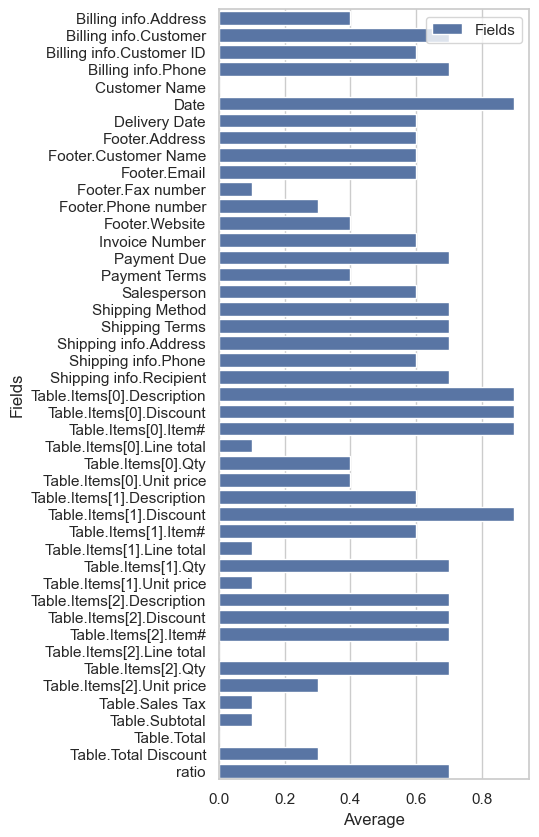

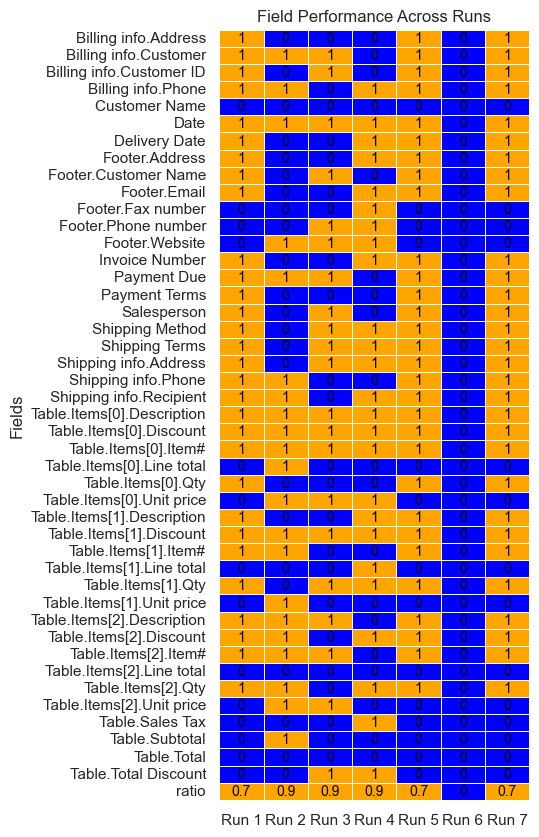

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

f, ax = plt.subplots(figsize=(4, 10))

merged_df.set_index('Fields', inplace=True)

sns.barplot(x="Average", y="Fields", data=merged_df, label="Fields", color="b")

plt.figure(figsize=(4, 10))
cmap = sns.color_palette(["blue", "orange"])
sns.heatmap(merged_df.iloc[:, :-1], annot=True, cmap=cmap, cbar=False, linewidths=.5, fmt='g', annot_kws={"size": 10, "color": "black"})
plt.title('Field Performance Across Runs')
plt.show()